<a href="https://colab.research.google.com/github/ajaysuseel/MiniProject_AD/blob/main/Copy_of_GNN_training_final_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ----------------------------
# Setup & Install Dependencies
# ----------------------------
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
-f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install -q torch-geometric
!pip install -q spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 39.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:

# ----------------------------
# Imports
# ----------------------------
from google.colab import drive
import os, json, random, multiprocessing, pickle
import networkx as nx
import spacy, nltk
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer, util
from nltk.corpus import wordnet as wn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
# ----------------------------
# Configuration
# ----------------------------
drive.mount('/content/drive')
CAPTIONS_JSON = "/content/drive/MyDrive/Gemini_Captions/kg_train_augmented.json"
VAL_CAPTIONS_JSON = "/content/drive/MyDrive/Gemini_Captions/kg_val_augmented.json"
KG_SAVE_PATH = "/content/drive/MyDrive/gemini_models/kg_models2/kg_graph_aug.gpickle"
MODEL_SAVE_PATH = "/content/drive/MyDrive/gemini_models/kg_models2/graphsage_classifier.pth"
KEYWORDS_PATH = "/content/drive/MyDrive/Gemini_Captions/kg_captions2/hazard_keywords.json"
NODE2ID_PATH = "/content/drive/MyDrive/Gemini_Captions/kg_captions2/node2id.json"
WEIGHTS_SAVE_PATH = "/content/drive/MyDrive/gemini_models/kg_models/optimized_weights.pt"
CHECKPOINT_DIR = "/content/drive/MyDrive/gemini_models/kg_models2/checkpoints"
FEATS_TRAIN_PATH = "/content/drive/MyDrive/gemini_models/kg_models2/precomputed_feats_train.pt"
FEATS_VAL_PATH = "/content/drive/MyDrive/gemini_models/kg_models2/precomputed_feats_val.pt"
BATCH_SIZE = 64
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:

# ----------------------------
# NLP and KG Initialization
# ----------------------------
nlp_fast = spacy.load("en_core_web_sm")
# nlp_trf = spacy.load("en_core_web_trf")
embedder = SentenceTransformer('all-MiniLM-L6-v2')
nltk.download("wordnet")
hazard_keywords = {
    "low": [
        ("clear road", 1.0), ("dry road", 1.0), ("daytime", 1.0), ("straight road", 1.0),
        ("good visibility", 1.0), ("no traffic", 1.0), ("open road", 1.0), ("well-lit", 1.0),
        ("sunny", 1.0), ("flat terrain", 1.0), ("light traffic", 1.0), ("wide road", 1.0)
    ],
    "medium": [
        ("moderate visibility", 1.5), ("residential area", 1.5), ("curved road", 1.5),
        ("slightly wet", 1.5), ("light rain", 1.5), ("children nearby", 1.5),
        ("cyclist", 1.5), ("school zone", 1.5), ("urban traffic", 1.5),
        ("construction zone", 1.6), ("intersections", 1.6), ("speed bumps", 1.5)
    ],
    "high": [
        ("poor visibility", 2.0), ("fog", 2.0), ("heavy rain", 2.1), ("pedestrian ahead", 2.2),
        ("jaywalking", 2.2), ("nighttime", 2.0), ("icy road", 2.3), ("sharp turn", 2.1),
        ("blind spot", 2.1), ("narrow lane", 2.0), ("heavy traffic", 2.0),
        ("obstruction", 2.1), ("collision", 2.5), ("emergency vehicle", 2.2), ("road closed", 2.3)
    ]
}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# ----------------------------
# Triplet Extraction and KG
# ----------------------------
def extract_triplets(caption):
    doc = nlp_fast(caption.lower())
    triples = []
    for token in doc:
        if token.dep_ in ("amod", "acomp") and token.head.pos_ == "NOUN":
            triples.append((token.head.lemma_, token.lemma_))
        elif token.dep_ == "attr" and token.head.pos_ == "NOUN":
            triples.append((token.head.lemma_, token.lemma_))
        elif token.dep_ == "nsubj" and token.head.pos_ in ("VERB", "AUX"):
            triples.append((token.text, token.head.lemma_))
    return triples

def build_graph(data):
    G = nx.DiGraph()
    with multiprocessing.Pool() as pool:
        all_triples = pool.map(extract_triplets, [item["description"] for item in data])
    for triples in all_triples:
        for u, v in triples:
            G.add_edge(u, v)
    for node in list(G.nodes()):
        syns = wn.synsets(node, pos=wn.NOUN) + wn.synsets(node, pos=wn.ADJ)
        for syn in syns:
            for lemma in syn.lemmas():
                other = lemma.name().replace("_", " ")
                if other in G and other != node:
                    G.add_edge(node, other)
                    G.add_edge(other, node)
    return G

with open(CAPTIONS_JSON) as f:
    train_captions = json.load(f)
if os.path.exists(KG_SAVE_PATH):
    G = pickle.load(open(KG_SAVE_PATH, "rb"))
else:
    G = build_graph(train_captions)
    os.makedirs(os.path.dirname(KG_SAVE_PATH), exist_ok=True)
    pickle.dump(G, open(KG_SAVE_PATH, "wb"))

node_to_idx = {n: i for i, n in enumerate(G.nodes())}
deg = dict(G.degree()); max_deg = max(deg.values()) or 1
edge_index = torch.tensor([[node_to_idx[u] for u, v in G.edges()],
                           [node_to_idx[v] for u, v in G.edges()]], dtype=torch.long)
x = torch.tensor([[deg[n]/max_deg] for n in G.nodes()], dtype=torch.float)
data_graph = Data(x=x, edge_index=edge_index).to(DEVICE)

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load model once globally
sem_model = SentenceTransformer('all-MiniLM-L6-v2')  # efficient and GPU-ready

# Precompute embeddings for keywords
hazard_keywords_emb = {}
for level in hazard_keywords:
    phrases = [phrase for phrase, _ in hazard_keywords[level]]
    weights = [weight for _, weight in hazard_keywords[level]]
    embeddings = sem_model.encode(phrases, convert_to_tensor=True)
    hazard_keywords_emb[level] = list(zip(embeddings, weights))

# Safe for multiprocessing (no CUDA)
def keyword_hazard_score(text, use_semantic=False):
    scores = [0.0, 0.0, 0.0]  # low, medium, high
    text_lc = text.lower()

    for i, level in enumerate(["low", "medium", "high"]):
        matches = [kw for kw, _ in hazard_keywords[level] if kw in text_lc]
        scores[i] = len(matches)

    # No semantic similarity here (GPU) — handled in main loop
    return torch.tensor(scores, dtype=torch.float)


In [ ]:


# # ----------------------------
# # Scoring Functions
# # ----------------------------
# def keyword_hazard_score(text):
#     txt = text.lower()
#     scores = [sum(txt.count(kw) * w for kw, w in hazard_keywords[l])
#               for l in ("low", "medium", "high")]
#     s = sum(scores) or 1
#     return torch.tensor([v / s for v in scores], dtype=torch.float)

def graph_context_score(caption):
    nodes = {u for u, _ in extract_triplets(caption)} | {v for _, v in extract_triplets(caption)}
    vals = [deg[n] / max_deg for n in nodes if n in deg]
    return torch.tensor([np.mean(vals) if vals else 0.0] * 3, dtype=torch.float)

def semantic_score(text):
    emb = embedder.encode(text, convert_to_tensor=True)
    sims = []
    for lvl in ("low", "medium", "high"):
        ph = [kw for kw, _ in hazard_keywords[lvl]]
        ph_embs = embedder.encode(ph, convert_to_tensor=True)
        sims.append(util.cos_sim(emb, ph_embs).max().item())
    s = sum(sims) or 1
    return torch.tensor([v / s for v in sims], dtype=torch.float)


In [ ]:
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count

def process_caption_for_feats(caption):
    k_score = keyword_hazard_score(caption, use_semantic=False)
    g_score = graph_context_score(caption)
    return torch.cat([k_score, g_score])

# Load data
with open(CAPTIONS_JSON) as f: train_data = json.load(f)
train_texts = [item["description"] for item in train_data]

if os.path.exists(FEATS_TRAIN_PATH):
    print("✅ Loading precomputed training features...")
    all_feats_train = torch.load(FEATS_TRAIN_PATH)
else:
    print("🔄 Precomputing training features (batched)...")

    # Step 1: CPU-parallel keyword + graph
    with Pool(cpu_count()) as p:
        kg_feats = list(tqdm(p.imap(process_caption_for_feats, train_texts),
                             total=len(train_texts), desc="Keyword + Graph"))

    # Step 2: Semantic embedding (main process, CUDA-safe)
    sem_feats = sem_model.encode(train_texts, convert_to_tensor=True, show_progress_bar=True)

    # Step 3: Compute per-level similarities
    semantic_levels = {
        lvl: sem_model.encode([kw for kw, _ in hazard_keywords[lvl]], convert_to_tensor=True)
        for lvl in ["low", "medium", "high"]
    }

    # Step 4: Combine all features
    all_feats_train = []
    for i, emb in enumerate(sem_feats):
        sims = [util.cos_sim(emb, semantic_levels[lvl]).max().item() for lvl in ["low", "medium", "high"]]
        sims = torch.tensor([v / (sum(sims) or 1) for v in sims], dtype=torch.float)
        all_feats_train.append(torch.cat([kg_feats[i], sims]))

    all_feats_train = torch.stack(all_feats_train)
    torch.save(all_feats_train, FEATS_TRAIN_PATH)
    print("✅ Saved training features.")


🔄 Precomputing training features (batched)...


Keyword + Graph:   0%|          | 0/26888 [00:00<?, ?it/s]

Batches:   0%|          | 0/841 [00:00<?, ?it/s]

✅ Saved training features.


In [ ]:
# Load validation data
with open(VAL_CAPTIONS_JSON) as f: val_data = json.load(f)
val_texts = [item["description"] for item in val_data]

if os.path.exists(FEATS_VAL_PATH):
    print("✅ Loading precomputed validation features...")
    all_feats_val = torch.load(FEATS_VAL_PATH)
else:
    print("🔄 Precomputing validation features (batched)...")

    with Pool(cpu_count()) as p:
        kg_feats = list(tqdm(p.imap(process_caption_for_feats, val_texts),
                             total=len(val_texts), desc="Keyword + Graph"))

    sem_feats = sem_model.encode(val_texts, convert_to_tensor=True, show_progress_bar=True)

    all_feats_val = []
    for i, emb in enumerate(sem_feats):
        sims = [util.cos_sim(emb, semantic_levels[lvl]).max().item() for lvl in ["low", "medium", "high"]]
        sims = torch.tensor([v / (sum(sims) or 1) for v in sims], dtype=torch.float)
        all_feats_val.append(torch.cat([kg_feats[i], sims]))

    all_feats_val = torch.stack(all_feats_val)
    torch.save(all_feats_val, FEATS_VAL_PATH)
    print("✅ Saved validation features.")


🔄 Precomputing validation features (batched)...


Keyword + Graph:   0%|          | 0/3091 [00:00<?, ?it/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Saved validation features.


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CaptionDataset(Dataset):
    def __init__(self, data, feat_tensor):
        self.data = data
        self.feats = feat_tensor
        self.label_map = {"low": 0, "medium": 1, "high": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        triples = extract_triplets(item["description"])
        nodes = [node_to_idx[n] for u, v in triples for n in (u, v) if n in node_to_idx]
        if not nodes:
            nodes = [0]
        return nodes, self.feats[idx], self.label_map[item["hazard_rating"].lower()]

def collate_fn(batch):
    nodes, heuristics, labels = zip(*batch)
    return list(nodes), torch.stack(heuristics), torch.tensor(labels)

# Load datasets
train_ds = CaptionDataset(train_data, all_feats_train)
val_ds  = CaptionDataset(val_data, all_feats_val)

In [ ]:

import torch.nn.functional as F  # ✅ Add this


In [ ]:
class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.sage3 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(dropout)

        # 🔁 Attention weights for pooling
        self.attn_weights = nn.Parameter(torch.randn(hidden_channels, 1))

        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels + 9, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, out_channels)
        )

    def forward(self, node_ids_batch, heuristics, data_graph):
        x, edge_index = data_graph.x, data_graph.edge_index
        x = self.sage1(x, edge_index).relu()
        x = self.sage2(x, edge_index).relu()
        x = self.sage3(x, edge_index).relu()

        node_feats = []
        for node_ids in node_ids_batch:
            node_embeds = x[node_ids]  # [num_nodes, hidden_dim]
            scores = torch.matmul(node_embeds, self.attn_weights)  # [num_nodes, 1]
            attn = F.softmax(scores, dim=0)  # softmax across nodes
            weighted = attn * node_embeds  # [num_nodes, hidden_dim]
            node_feat = weighted.sum(dim=0)  # weighted sum
            node_feats.append(node_feat)

        graph_feat = torch.stack(node_feats)
        combined = torch.cat([graph_feat, heuristics], dim=1)
        return self.mlp(combined)


In [ ]:
# Safely load full object (not just weights-only)
weights = torch.load(WEIGHTS_SAVE_PATH, weights_only=False)
alpha, beta, gamma = weights['alpha'], weights['beta'], weights['gamma']
print(f"Using α={alpha:.2f}, β={beta:.2f}, γ={gamma:.2f}")


Using α=0.20, β=0.70, γ=0.10


In [ ]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=NUM_WORKERS)


In [ ]:
import warnings
import signal
from tqdm.notebook import tqdm  # 👈 cleaner notebook-friendly progress bar

# Patch: Suppress multiprocessing `DataLoader` deletion errors
import multiprocessing.util
multiprocessing.util._exit_function = lambda *args, **kwargs: None

model = GraphSAGEClassifier(in_channels=1, hidden_channels=128, out_channels=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
loss_fn = nn.CrossEntropyLoss()

best_val_acc = 0
patience = 5
counter = 0
EPOCHS = 40
train_losses, val_losses = [], []

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def ask_to_continue():
    try:
        response = input("🔄 Continue training? (y/n): ").strip().lower()
        return response == 'y'
    except Exception as e:
        print("⚠️ Input error, stopping training for safety.")
        return False

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for nodes, heur, labels in tqdm(train_loader, desc=f"Epoch {epoch:02d} [Train]", leave=False):
        heur, labels = heur.to(DEVICE), labels.to(DEVICE)
        out = model(nodes, heur, data_graph)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        train_correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    train_acc = train_correct / total
    avg_train_loss = train_loss / total
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, total = 0, 0, 0
    with torch.no_grad():
        for nodes, heur, labels in tqdm(val_loader, desc=f"Epoch {epoch:02d} [Val]", leave=False):
            heur, labels = heur.to(DEVICE), labels.to(DEVICE)
            out = model(nodes, heur, data_graph)
            loss = loss_fn(out, labels)

            val_loss += loss.item() * labels.size(0)
            val_correct += (out.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = val_correct / total
    avg_val_loss = val_loss / total
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print("🔼 Best model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

    # Ask every 10 epochs
    if epoch % 10 == 0 and epoch != EPOCHS:
        if not ask_to_continue():
            print("🛑 Training halted by user.")
            break


Epoch 01 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 01 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 01 | Train Acc: 0.6560 | Train Loss: 0.7702 | Val Acc: 0.7532 | Val Loss: 0.6370
🔼 Best model saved.


Epoch 02 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 02 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 02 | Train Acc: 0.7107 | Train Loss: 0.6762 | Val Acc: 0.7638 | Val Loss: 0.6045
🔼 Best model saved.


Epoch 03 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 03 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 03 | Train Acc: 0.7351 | Train Loss: 0.6287 | Val Acc: 0.7739 | Val Loss: 0.5702
🔼 Best model saved.


Epoch 04 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 04 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 04 | Train Acc: 0.7599 | Train Loss: 0.5805 | Val Acc: 0.7810 | Val Loss: 0.5457
🔼 Best model saved.


Epoch 05 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 05 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 05 | Train Acc: 0.7855 | Train Loss: 0.5339 | Val Acc: 0.8088 | Val Loss: 0.5123
🔼 Best model saved.


Epoch 06 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 06 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 06 | Train Acc: 0.7963 | Train Loss: 0.5070 | Val Acc: 0.8137 | Val Loss: 0.4972
🔼 Best model saved.


Epoch 07 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 07 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 07 | Train Acc: 0.8056 | Train Loss: 0.4854 | Val Acc: 0.8120 | Val Loss: 0.4935


Epoch 08 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 08 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 08 | Train Acc: 0.8080 | Train Loss: 0.4774 | Val Acc: 0.8075 | Val Loss: 0.5079


Epoch 09 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 09 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 09 | Train Acc: 0.8161 | Train Loss: 0.4658 | Val Acc: 0.8169 | Val Loss: 0.4849
🔼 Best model saved.


Epoch 10 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10 | Train Acc: 0.8146 | Train Loss: 0.4619 | Val Acc: 0.8146 | Val Loss: 0.4837
🔄 Continue training? (y/n): y


Epoch 11 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11 | Train Acc: 0.8203 | Train Loss: 0.4504 | Val Acc: 0.8243 | Val Loss: 0.4808
🔼 Best model saved.


Epoch 12 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12 | Train Acc: 0.8231 | Train Loss: 0.4449 | Val Acc: 0.8295 | Val Loss: 0.4671
🔼 Best model saved.


Epoch 13 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13 | Train Acc: 0.8232 | Train Loss: 0.4391 | Val Acc: 0.8279 | Val Loss: 0.4881


Epoch 14 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14 | Train Acc: 0.8269 | Train Loss: 0.4314 | Val Acc: 0.8344 | Val Loss: 0.4601
🔼 Best model saved.


Epoch 15 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15 | Train Acc: 0.8288 | Train Loss: 0.4303 | Val Acc: 0.8382 | Val Loss: 0.4521
🔼 Best model saved.


Epoch 16 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16 | Train Acc: 0.8325 | Train Loss: 0.4205 | Val Acc: 0.8428 | Val Loss: 0.4445
🔼 Best model saved.


Epoch 17 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17 | Train Acc: 0.8326 | Train Loss: 0.4181 | Val Acc: 0.8402 | Val Loss: 0.4496


Epoch 18 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18 | Train Acc: 0.8372 | Train Loss: 0.4097 | Val Acc: 0.8428 | Val Loss: 0.4469


Epoch 19 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19 | Train Acc: 0.8372 | Train Loss: 0.4074 | Val Acc: 0.8492 | Val Loss: 0.4407
🔼 Best model saved.


Epoch 20 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20 | Train Acc: 0.8385 | Train Loss: 0.4076 | Val Acc: 0.8431 | Val Loss: 0.4356
🔄 Continue training? (y/n): y


Epoch 21 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21 | Train Acc: 0.8407 | Train Loss: 0.4009 | Val Acc: 0.8502 | Val Loss: 0.4506
🔼 Best model saved.


Epoch 22 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22 | Train Acc: 0.8428 | Train Loss: 0.3944 | Val Acc: 0.8499 | Val Loss: 0.4226


Epoch 23 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23 | Train Acc: 0.8439 | Train Loss: 0.3914 | Val Acc: 0.8499 | Val Loss: 0.4454


Epoch 24 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24 | Train Acc: 0.8465 | Train Loss: 0.3888 | Val Acc: 0.8476 | Val Loss: 0.4283


Epoch 25 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 25 | Train Acc: 0.8486 | Train Loss: 0.3847 | Val Acc: 0.8512 | Val Loss: 0.4393
🔼 Best model saved.


Epoch 26 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 26 | Train Acc: 0.8464 | Train Loss: 0.3820 | Val Acc: 0.8486 | Val Loss: 0.4394


Epoch 27 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 27 | Train Acc: 0.8502 | Train Loss: 0.3808 | Val Acc: 0.8512 | Val Loss: 0.4299


Epoch 28 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 28 | Train Acc: 0.8506 | Train Loss: 0.3768 | Val Acc: 0.8502 | Val Loss: 0.4238


Epoch 29 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 29 | Train Acc: 0.8524 | Train Loss: 0.3748 | Val Acc: 0.8492 | Val Loss: 0.4331


Epoch 30 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 30 | Train Acc: 0.8532 | Train Loss: 0.3716 | Val Acc: 0.8525 | Val Loss: 0.4265
🔼 Best model saved.
🔄 Continue training? (y/n): yes
🛑 Training halted by user.


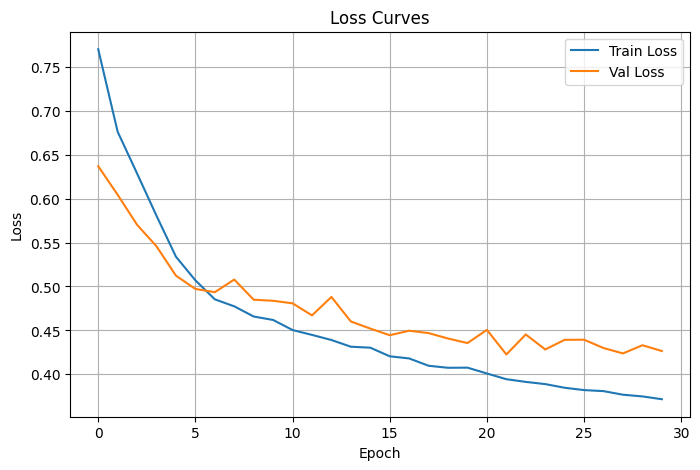

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
plt.savefig("/content/drive/MyDrive/gemini_models/kg_models2/loss_curve.png")

In [ ]:
# Save final trained model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Saved model to {MODEL_SAVE_PATH}")

# Save hazard keywords
with open(KEYWORDS_PATH, "w") as f:
    json.dump(hazard_keywords, f)
print(f"✅ Saved hazard keywords to {KEYWORDS_PATH}")

# Save node-to-id mapping
with open(NODE2ID_PATH, "w") as f:
    json.dump(node_to_idx, f)
print(f"✅ Saved node-to-id mapping to {NODE2ID_PATH}")

# # Save tuned alpha, beta, gamma weights
# torch.save({'alpha': alpha, 'beta': beta, 'gamma': gamma}, WEIGHTS_SAVE_PATH)
# print(f"✅ Saved alpha, beta, gamma to {WEIGHTS_SAVE_PATH}")


✅ Saved model to /content/drive/MyDrive/gemini_models/kg_models2/graphsage_classifier.pth
✅ Saved hazard keywords to /content/drive/MyDrive/Gemini_Captions/kg_captions2/hazard_keywords.json
✅ Saved node-to-id mapping to /content/drive/MyDrive/Gemini_Captions/kg_captions2/node2id.json
